In [1]:
import glob
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# Testing

## .mp3 Format

### Load Audio

In [ ]:
audio_path1 = './The Beatles/Please Please Me/01 I Saw Her Standing There.mp3'

In [ ]:
y1, sr1 = librosa.load(audio_path1)

### Mel Spectrograms

In [ ]:
S1 = librosa.feature.melspectrogram(y1, sr=sr1, n_mels=128)
log_S1 = librosa.power_to_db(S1, ref=np.max)
plt.figure(figsize=(16,8))
librosa.display.specshow(log_S1, sr=sr1, x_axis='time', y_axis='mel')
plt.title("Mel Power Sprectrogram")
plt.colorbar(format='%+02.0f dB');

In [ ]:
y_harmonic1, y_percussive1 = librosa.effects.hpss(y1)

In [ ]:
S1 = librosa.feature.melspectrogram(y_harmonic1, sr=sr1, n_mels=128)
log_S1 = librosa.power_to_db(S1, ref=np.max)
plt.figure(figsize=(16,8))
librosa.display.specshow(log_S1, sr=sr1, x_axis='time', y_axis='mel')
plt.title("Mel Power Sprectrogram: Melodic Elements")
plt.colorbar(format='%+02.0f dB');

In [ ]:
S1 = librosa.feature.melspectrogram(y_percussive1, sr=sr1, n_mels=128)
log_S1 = librosa.power_to_db(S1, ref=np.max)
plt.figure(figsize=(16,8))
librosa.display.specshow(log_S1, sr=sr1, x_axis='time', y_axis='mel')
plt.title("Mel Power Sprectrogram: Percussive Elements")
plt.colorbar(format='%+02.0f dB');

### Chromagram

In [ ]:
C1 = librosa.feature.chroma_cqt(y_harmonic1, sr=sr1)

plt.figure(figsize=(16,8))
librosa.display.specshow(C1, sr=sr1, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title("Chromagram", fontsize=20)
plt.colorbar()
plt.tight_layout();

## .wav Format

### Load Audio

In [ ]:
audio_path2 = './The Beatles/wav_files/01 I Saw Her Standing There.wav'

In [ ]:
y2, sr2 = librosa.load(audio_path2)

### Mel Spectrograms

In [ ]:
S2 = librosa.feature.melspectrogram(y2, sr=sr2, n_mels=128)
log_S2 = librosa.power_to_db(S2, ref=np.max)
plt.figure(figsize=(16,8))
librosa.display.specshow(log_S2, sr=sr2, x_axis='time', y_axis='mel')
plt.title("Mel Power Sprectrogram")
plt.colorbar(format='%+02.0f dB');

In [ ]:
y_harmonic2, y_percussive2 = librosa.effects.hpss(y2)

In [ ]:
S2 = librosa.feature.melspectrogram(y_harmonic2, sr=sr2, n_mels=128)
log_S2 = librosa.power_to_db(S2, ref=np.max)
plt.figure(figsize=(16,8))
librosa.display.specshow(log_S2, sr=sr2, x_axis='time', y_axis='mel')
plt.title("Mel Power Sprectrogram: Melodic Elements")
plt.colorbar(format='%+02.0f dB');

In [ ]:
S2 = librosa.feature.melspectrogram(y_percussive2, sr=sr2, n_mels=128)
log_S2 = librosa.power_to_db(S2, ref=np.max)
plt.figure(figsize=(16,8))
librosa.display.specshow(log_S2, sr=sr2, x_axis='time', y_axis='mel')
plt.title("Mel Power Sprectrogram: Percussive Elements")
plt.colorbar(format='%+02.0f dB');

### Chromagram

In [ ]:
C2 = librosa.feature.chroma_cqt(y_harmonic2, sr=sr2)

plt.figure(figsize=(16,8))
librosa.display.specshow(C2, sr=sr2, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title("Chromagram", fontsize=20)
plt.colorbar()
plt.tight_layout();

# Pipeline

In [2]:
import glob
import pandas as pd
import re
from io import StringIO
import numpy as np
from scipy.io import wavfile
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Using TensorFlow backend.
/Users/davidoxnard/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Create DataFrames

In [3]:
labels_filepath = './The Beatles Annotations/chordlab/The Beatles/*/*.lab'
features_filepath = './The Beatles/wav_files/*.wav'

In [4]:
labels = pd.DataFrame()

labels['label_file'] = glob.glob(labels_filepath)
labels['inferred_name'] = labels.label_file.apply(lambda x: re.sub(r'[0-9_\-]+', ' ', x).split('/')[-1].split('.lab')[0].split('CD')[-1].strip().lower())

In [5]:
features = pd.DataFrame()

features['feature_file'] = glob.glob(features_filepath)
features['inferred_name'] = features.feature_file.apply(lambda x: re.sub(r'[0-9]+', '', x).split('/')[-1].split('.wav')[0].strip().lower())

## Define Preprocessing Functions

In [6]:
key_map = {
    
    # Maj chords, all enharmonic equivalents
    'A':0,
    'B':1,
    'C':2,
    'D':3,
    'E':4,
    'F':5,
    'G':6,
    'Ab':7,
    'Abb':7,
    'Bb':8,
    'Bbb':8,
    'Cb':1,
    'Db':9,
    'Eb':10,
    'Fb':4,
    'Gb':11,
    'A#':8,
    'B#':2,
    'C#':9,
    'D#':10,
    'E#':5,
    'F#':11,
    'G#':7,
    
    # Min chords, all enharmonic equivalents.
    'A min':12,
    'B min':13,
    'C min':14,
    'D min':15,
    'E min':16,
    'F min':17,
    'G min':18,
    'Ab min':19,
    'Bb min':20,
    'Cb min':13,
    'Db min':21,
    'Eb min':22,
    'Fb min':16,
    'Gb min':23,
    'A# min':20,
    'B# min':14,
    'C# min':21,
    'D# min':22,
    'E# min':17,
    'F# min':23,
    'G# min':19,
    
    # None
    'N': 24
}

In [7]:
relative_map = {
    
    # Maj chords, all enharmonic equivalents
    'A':0,
    'B':1,
    'C':2,
    'D':3,
    'E':4,
    'F':5,
    'G':6,
    'Ab':7,
    'Abb':7,
    'Bb':8,
    'Bbb':8,
    'Cb':1,
    'Db':9,
    'Eb':10,
    'Fb':4,
    'Gb':11,
    'A#':8,
    'B#':2,
    'C#':9,
    'D#':10,
    'E#':5,
    'F#':11,
    'G#':7,
    
    # Min chords, all enharmonic equivalents.
    'A min':2,
    'B min':3,
    'C min':10,
    'D min':5,
    'E min':6,
    'F min':7,
    'G min':8,
    'Ab min':1,
    'Bb min':9,
    'Cb min':3,
    'Db min':4,
    'Eb min':11,
    'Fb min':6,
    'Gb min':0,
    'A# min':9,
    'B# min':10,
    'C# min':4,
    'D# min':11,
    'E# min':7,
    'F# min':0,
    'G# min':1,
    
    # None
    'N': 12
}

In [8]:
cof_map = {
    
    0:4,
    1:6,
    2:1,
    3:3,
    4:5,
    5:0,
    6:2,
    7:9,
    8:11,
    9:8,
    10:10,
    11:7,
    12:12,
}

In [9]:
def chromagram_plot(clip, rate):
    """Helper function for plotting chromagram of audio segments."""
    
    plt.figure(figsize=(8,4))
    librosa.display.specshow(clip, sr=rate, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
    plt.title("Chromagram", fontsize=20)
    plt.colorbar()
    plt.tight_layout();

In [10]:
def create_chromagram(start_sec, stop_sec, filename, channel='both'):
    
    rate, wave = wavfile.read(filename)
    start = int(start_sec * rate)
    stop = int(stop_sec * rate)
    
    # Can switch these guys in and out!
    left_channel = wave[start:stop,0] # One of the two stereo channels
    right_channel = wave[start:stop,1] # Second of the two stereo channels
    mean_channel = np.mean(wave[start:stop], axis=1) # Mean of the two stereo channels.  Might also be a way to get mono from scipy.
    
    if channel == 'both':
        wave = mean_channel.astype('float64')
    elif channel == 'left':
        wave = left_channel.astype('float64')
    elif channel == 'right':
        wave = right_channel.astype('float64')
    else:
        print("ERROR at {0}: PLEASE SELECT A VALID CHANNEL: {'left', 'right', 'both'}".format(filename))
    
    wave_harmonic, wave_percussive = librosa.effects.hpss(wave)
    
    C = librosa.feature.chroma_cqt(wave_harmonic, sr=rate)
    
    return C, rate

In [11]:
def get_timestamps(filename, dictionary):
    """
    Insert name, start, stop and msucial key into the passed distionary.
    To use in iterating over annotation files.
    """
    
    with open(filename, 'r') as f_obj:
        text = f_obj.readlines()
        inferred_name = re.sub(r'[0-9_\-]+', ' ', filename).split('/')[-1].split('.lab')[0].split('CD')[-1].strip().lower()
        end_stamp = float(text[-1].split()[1])   # relic of an old idea.
        for line in text:
            line = line.split()        
            start = float(line[0])
            stop = float(line[1])
            musical_key = line[2]
            new_key = (inferred_name, start, stop)
            dictionary[new_key] = musical_key

In [12]:
def clean_ys(y):
    """
    Substitute complex chords into their simple maj/min versions.
    """

    for i, chord in enumerate(y):
        if not len(chord) == 1:
            chord = chord.split(':')
            tonality = re.sub(r'[0-9/]+', '', chord[0])
            flavor = chord[-1]
            if "min" in flavor:
                y[i] = tonality + ' min'
            else:
                y[i] = tonality
    return y

In [13]:
def add_padding(x, maxlen=500):
    """Pad/trim so that every sample has the same length."""
    
    # May want to increase maxlen from 500! Not sure the total dist of chomragram lengths.

    for i in range(len(x)):
        x[i] = x[i][:,:maxlen]
        q = maxlen - x[i].shape[1]
        p = q//2
#         if q % 2 == 0:
#             x[i] = np.pad(x[i], ((p,p), (0,0)), 'constant', constant_values=(0,0))
#         else:
#             x[i] = np.pad(x[i], ((p,p+1), (0,0)), 'constant', constant_values=(0,0))

        print
        if q % 2 == 0:
            x[i] = np.pad(x[i], ((0,0), (p,p)), 'constant', constant_values=(0,0))
        else:
            x[i] = np.pad(x[i], ((0,0), (p,p+1)), 'constant', constant_values=(0,0))
            
    return x

In [14]:
# Constructs X and Y.
# Took 37.5s for TEST_SIZE = 1.
# Took 5m 6s for TEST_SIZE = 10.
# Took 24m 56s for TEST_SIZE = 50.
# Took 2h 26m 4s for TEST_SIZE = 180.
# Took 1h 49m 53s for TEST_SIZE = 180 another time.

def construct_vars(lookup):
    """
    Pass the dictionary of songs/timestamps/keys.
    Create the corresponding x and y variables.
    """
    
    x_chroma = []
    y = []
    
    
    for k, v in lookup.items():
        
        inferred, start, stop = k
        musical_key = v

        filename = features[features.inferred_name == inferred].feature_file.values[0]

        try:
            x_chroma.append(create_chromagram(start, stop, filename, channel='both')[0])
            y.append(v)
        except:
            print("CHROMA ERROR:\nStart: {0}\nStop: {1}\nName: {2}\n\n\n".format(start, stop, inferred))
    
    x_chroma = add_padding(x_chroma)
    x = np.zeros((len(x_chroma), x_chroma[0].shape[0], x_chroma[0].shape[1]))
    for i in range(len(x)):
        x[i,:,:] = x_chroma[i]
    
    
    y = clean_ys(y)
    y = list(map(lambda x: relative_map[x], y))    # Switched out key_map  
    
    return x, y

## Create Features, Labels

In [34]:
lookup = {}

TEST_SIZE = 50


for filename in labels.label_file[:TEST_SIZE]:
    get_timestamps(filename, lookup)

In [35]:
x, y = construct_vars(lookup)

/Users/davidoxnard/anaconda/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


CHROMA ERROR:
Start: 125.251687
Stop: 126.226925
Name: words of love



CHROMA ERROR:
Start: 126.226925
Stop: 128.258671
Name: words of love



CHROMA ERROR:
Start: 128.258671
Stop: 129.245519
Name: words of love



CHROMA ERROR:
Start: 129.245519
Stop: 133.024226
Name: words of love



CHROMA ERROR:
Start: 133.024226
Stop: 134.739592
Name: words of love





In [36]:
len(y), x.shape

(3797, (3797, 12, 500))

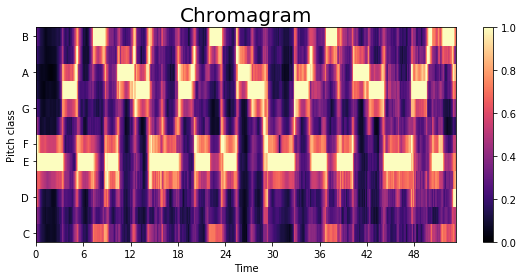

In [37]:
chromagram_plot(x[1], 4800)

In [38]:
x[1].shape

(12, 500)

In [39]:
x.shape

(3797, 12, 500)

In [40]:
x_reshaped = np.reshape(x, (x.shape[0], 12, 500, 1))

In [41]:
y_mapped_to_cof = list(map(lambda x: cof_map[x], y))

# Neural Net

In [23]:
def top_3(y_true, y_pred):
    return keras.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

In [ ]:
nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

In [94]:
def my_fit(model_layers):

    model = keras.Sequential(model_layers)

    model.summary()

    model.compile(
        loss='sparse_categorical_crossentropy',
#         loss='mean_absolute_error',
        optimizer='nadam',
#         optimizer=nadam,
        metrics=['accuracy']) #, top_3])

    history = model.fit(
        x_reshaped,
        y,
        batch_size=100,
        epochs=50,
        verbose=1,
        validation_split=.2,
        callbacks=[keras.callbacks.EarlyStopping(verbose=1)])

#     plot_history(history)

    return model #, history

In [95]:
init_stddev = 0.01
dropout_prob = 0.5
num_labels = max(y)+1

In [96]:
# Single Dense Layer.

model_layers1 = [
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),
    keras.layers.Flatten(),
    keras.layers.Dropout(.9),
    
    keras.layers.Dense(16, activation='relu'),

    # Classification
    keras.layers.Dense(
        max(y)+1,
        activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=0.01)),
]

In [61]:
# Epoch 6: val_acc: 0.6039 - val_top_3: 0.8434

model_layers2 =[
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),

    # Conv layer
    keras.layers.Conv2D(
        186,
        kernel_size=(8, x_reshaped[0].shape[1]),
        padding="valid",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_prob),

    # Hidden Layer 1
    keras.layers.Dense(
        128,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),
    
    # Class Layer 2
    keras.layers.Dense(
        num_labels,
        activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
]

In [79]:
# Epoch 2: val_acc: 0.2211 - val_top_3: 0.4145

model_layers3 = [
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),

    # conv layer 1
    keras.layers.Conv2D(
        64,
        kernel_size=(5, 5),
        padding="same",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.MaxPool2D(
        pool_size=(2, 2), 
        strides=(2, 2), 
        padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_prob),

    # Conv layer 2
    keras.layers.Conv2D(
        64,
        kernel_size=(4, 10),
        padding="same",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.MaxPool2D(
        pool_size=(2, 2), 
        strides=(2, 2), 
        padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_prob),
    
    # Hidden Layer
    keras.layers.Dense(
        num_labels,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),

    # Classification
    keras.layers.Dense(
        num_labels,
        activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
]

In [ ]:


model_layers4 =[
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),

    # Conv layer
    keras.layers.Conv2D(
        16,
        kernel_size=(4, 4),
        padding="valid",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_prob),

    # Hidden Layer 1
    keras.layers.Dense(
        64,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),
    
    # Class Layer 2
    keras.layers.Dense(
        num_labels,
        activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
]

In [ ]:


model_layers5 =[
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),

    # Conv layer
    keras.layers.Conv2D(
        16,
        kernel_size=(6, 6),
        padding="valid",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_prob),

    # Hidden Layer 1
    keras.layers.Dense(
        64,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),
    
    # Class Layer 2
    keras.layers.Dense(
        num_labels,
        activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
]

In [21]:


model_layers6 =[
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),

    # Conv layer
    keras.layers.Conv2D(
        16,
        kernel_size=(6, 100),
        padding="valid",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_prob),

    # Hidden Layer 1
    keras.layers.Dense(
        64,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),
    
    # Class Layer 2
    keras.layers.Dense(
        num_labels,
        activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
]

In [ ]:


model_layers7 =[
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),

    # Conv layer
    keras.layers.Conv2D(
        16,
        kernel_size=(6, 100),
        padding="valid",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.MaxPool2D(
        pool_size=(3, 100), 
        strides=(2, 2), 
        padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_prob),

    # Hidden Layer 1
    keras.layers.Dense(
        64,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),
    
    # Class Layer 2
    keras.layers.Dense(
        num_labels,
        activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
]

In [81]:
# Epoch 6: val_acc: 0.5763 - val_top_3: 0.7987

model_layers8 =[
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),

    # Conv layer
    keras.layers.Conv2D(
        16,
        kernel_size=(6, 100),
        padding="valid",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
#     keras.layers.MaxPool2D(
#         pool_size=(3, 100), 
#         strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_prob),

    # Hidden Layer 1
    keras.layers.Dense(
        256,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),
    
    # Class Layer 2
    keras.layers.Dense(
        num_labels,
        activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
]

In [112]:
# Didn't get the dimensions to work.

model_layers9 =[
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),

    # Conv layer
    keras.layers.Conv2D(
        16,
        kernel_size=(6, 100),
        padding="valid",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.MaxPool2D(
        pool_size=(3, 100), 
        strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_prob),

    # Hidden Layer 1
    keras.layers.Dense(
        16,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),
    
    # Class Layer 2
    keras.layers.Dense(
        num_labels,
        activation="linear",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
]

In [83]:


model_layers10 =[
    keras.layers.InputLayer(input_shape=x_reshaped[0].shape),

    # Conv layer
    keras.layers.Conv2D(
        16,
        kernel_size=(6, 100),
        padding="valid",
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
#     keras.layers.MaxPool2D(
#         pool_size=(3, 100), 
#         strides=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(dropout_prob),

    # Hidden Layer 1
    keras.layers.Dense(
        256,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),
        keras.layers.Dense(
        16,
        activation="relu",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
    keras.layers.Dropout(dropout_prob),
    
    # Class Layer 2
    keras.layers.Dense(
        num_labels,
        activation="softmax",
        kernel_initializer=keras.initializers.TruncatedNormal(
            stddev=init_stddev)),
]

In [97]:
model = my_fit(model_layers1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 12, 500, 1)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 6000)              0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 6000)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 16)                96016     
_________________________________________________________________
dense_29 (Dense)             (None, 13)                221       
Total params: 96,237
Trainable params: 96,237
Non-trainable params: 0
_________________________________________________________________
Train on 3037 samples, validate on 760 samples
Epoch 1/50
3037/3037 [==============================] - 2s 645us/step - loss: 2.2074 - acc:

In [98]:
# save_filepath = 'dec10_test_model.h5'
# model.save(save_filepath)

In [101]:
y_pred = model.predict(np.reshape(x[0], (1, 12, 500, 1)))

In [107]:
probs = []
for i in range(62):
    probs.append(np.max(model.predict(np.reshape(x[i], (1, 12, 500, 1)))))

In [109]:
probs

[0.30241385,
 0.90174961,
 0.53617287,
 0.91697454,
 0.35139337,
 0.4716121,
 0.28480408,
 0.79281527,
 0.4415254,
 0.70684123,
 0.52354759,
 0.94531286,
 0.54144096,
 0.95802259,
 0.34432465,
 0.53386366,
 0.34266254,
 0.77141178,
 0.40955931,
 0.71223009,
 0.40662208,
 0.80607009,
 0.72866893,
 0.39284682,
 0.40612495,
 0.81848979,
 0.55085164,
 0.90922451,
 0.27508846,
 0.82582748,
 0.80808175,
 0.50752753,
 0.5903303,
 0.37849727,
 0.73843551,
 0.29977426,
 0.92609209,
 0.63983876,
 0.59841722,
 0.27958024,
 0.70726234,
 0.61399806,
 0.35262609,
 0.38631004,
 0.80617106,
 0.51765603,
 0.83834893,
 0.25535318,
 0.66514927,
 0.23748206,
 0.75137252,
 0.46714652,
 0.57431757,
 0.43766975,
 0.93448758,
 0.36303568,
 0.94663274,
 0.32825744,
 0.67180616,
 0.28675279,
 0.37876764,
 0.63557887]